In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

while os.getcwd().split(os.sep)[-1] != "neurolib":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_singlenode, plot_oc_network

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

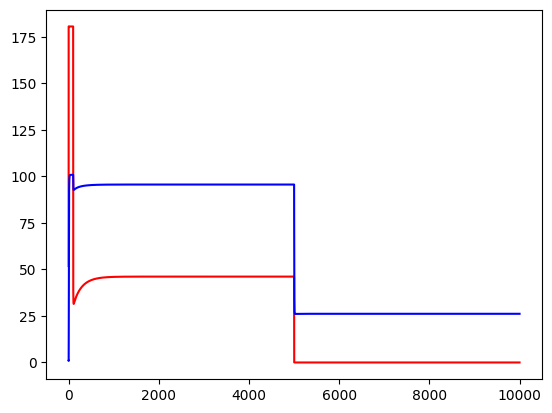

In [55]:
model = ALNModel()
model.params.mue_ext_mean = 0.5 * 1000./model.params.C
model.params.mui_ext_mean = 0.5 * 1000./model.params.C

model.params.de = 0.0
model.params.di = 0.0

model.params.a = 0.
model.params.b = 0.
dt = model.params.dt

model.params.duration = 10000.
zero_input = ZeroInput().generate_input(duration=model.params.duration+dt, dt=dt)
input = zero_input.copy()
input[0,:1000] = 10.
input[0,50000:51000] = -10.
model.params.ext_exc_current = input
model.run()
plt.plot(model.t, model.rates_exc[0,:], color="red")
plt.plot(model.t, model.rates_inh[0,:], color="blue")
plt.show()

rates_up = np.array( [ np.mean(model.rates_exc[0,45000:49000]), np.mean(model.rates_inh[0,45000:49000]) ])
rates_down = np.array( [ np.mean(model.rates_exc[0,95000:99000]), np.mean(model.rates_inh[0,95000:99000]) ])

setinitstate(model, getfinalstate(model))

duration = 100.
model.params.duration = duration
zero_control = np.zeros((model.params.N, 2, int(duration/dt)+1))
model.params.ext_exc_current = zero_control[:,0,:]
model.run()

target = getstate(model)
target[0,0,:] = rates_up[0]
target[0,1,:] = rates_up[1]

Compute control for a deterministic system
Cost in iteration 0: 106672.02936599951
Cost in iteration 25: 3135.2210289139907
Cost in iteration 50: 2115.616642001039
Cost in iteration 75: 1691.3603915258923
Cost in iteration 100: 1446.5203158049153
Final cost : 1446.5203158049153


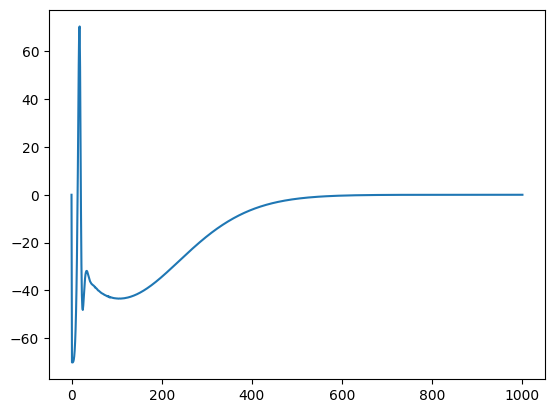

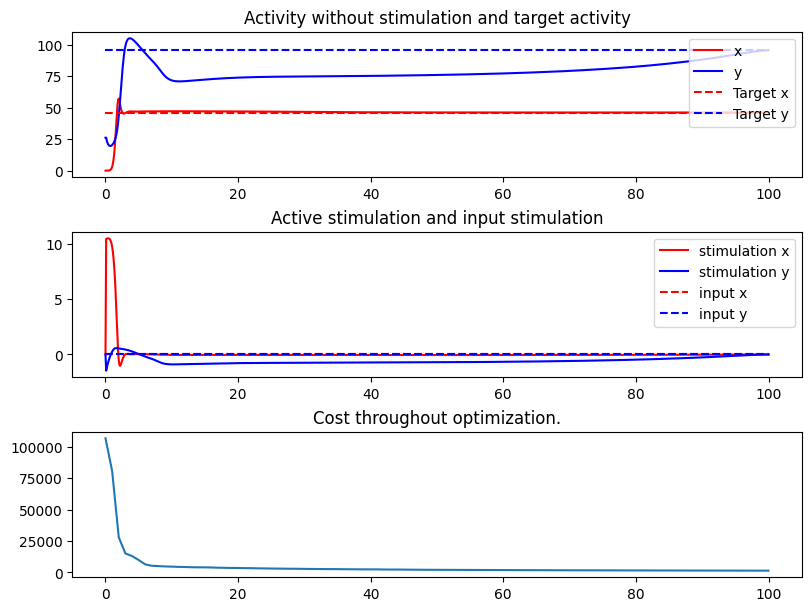

In [56]:
control_mat = np.zeros( (model.params.N, len(model.state_vars)) )
control_mat[0,0] = 1.
control_mat[0,1] = 1.
cost_mat = np.zeros( (model.params.N, len(model.output_vars)) )
cost_mat[0,0] = 1.

model.params["ext_exc_current"] = zero_control[:,0,:]
model.params["ext_inh_current"] = zero_control[:,1,:]

model_controlled = oc_aln.OcAln(model, target, print_array=np.arange(0,501,25), control_matrix=control_mat, cost_matrix=cost_mat)
model_controlled.optimize(100)

plt.plot(model_controlled.gradient[0,0,:])
plt.show()

state = model_controlled.get_xs()
control = model_controlled.control
init_control = np.zeros(control.shape)

plot_oc_singlenode(duration, dt, state, target, control, init_control, model_controlled.cost_history)